<h1>Amazon Inventory Reconciliation Using AI</h1>

# Problem Statement
Inventory management is critical to Amazon’s success. Thus, the need arises to apply artificial intelligence to assure the correctness of deliveries.

Amazon Fulfillment Centers are bustling hubs of innovation that allow Amazon to deliver millions of products to over 100 countries worldwide. These products are randomly placed in bins, which are carried by robots.

Occasionally, items are misplaced while being handled, resulting in a mismatch: the recorded bin inventory, versus its actual content.

The project predicts the number of items in a bin, thus detecting any inventory variance. By correcting variance upon detection, Amazon will better serve its customers.

Note: This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

<h3>Install and import</h3>

In [2]:
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import boto3
import sagemaker
import smdebug
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

<h3> Data Preparation </h3>

Get the data and copy it to S3

Run the cell below to download the data.

The cell below creates a folder called train_data, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder 1 has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found here). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [9]:
def download_data():
    s3_client = boto3.client('s3')

    with open('data.json', 'r') as f:
        data = json.load(f)

    for k, v in data.items():
        print(f"Downloading Images with {k} objects")
        directory = os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
          
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))
download_data()

  0%|          | 1/1228 [00:00<02:48,  7.28it/s]

  0%|          | 1/2299 [00:00<03:57,  9.67it/s]

  0%|          | 2/2666 [00:00<03:23, 13.08it/s]

  0%|          | 2/2373 [00:00<03:01, 13.09it/s]

  0%|          | 2/1875 [00:00<02:04, 15.08it/s]

100%|██████████| 1875/1875 [02:39<00:00, 11.77it/s]


### Dataset
TODO: Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data here.

In [3]:
classes = {1 : len([name for name in os.listdir('train_data/1')]),
           2 : len([name for name in os.listdir('train_data/2')]),
           3 : len([name for name in os.listdir('train_data/3')]),
           4 : len([name for name in os.listdir('train_data/4')]),
           5 : len([name for name in os.listdir('train_data/5')]),}
classes

{1: 1229, 2: 2299, 3: 2666, 4: 2373, 5: 1875}

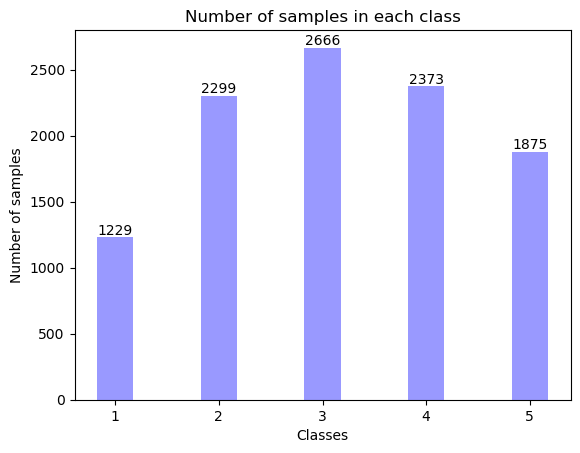

In [4]:
opacity = 0.4
bar_width = 0.35

bar = plt.bar(classes.keys(), classes.values(), bar_width, align='center', alpha=opacity, color='b')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

plt.title("Number of samples in each class")
plt.xlabel("Classes")
plt.ylabel("Number of samples")

plt.show()

The data is inbalanced so, we can download more data from amazon bin inventory dataset or use oversampling techniques

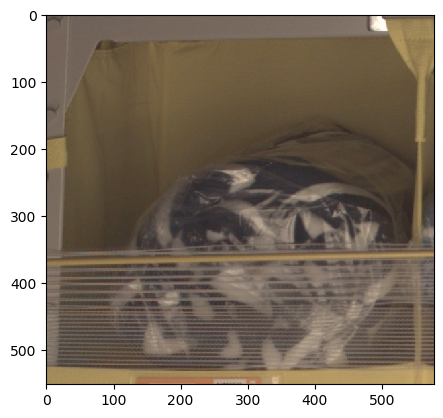

In [12]:
imgSample = plt.imread(f"train_data/1/{random.sample(os.listdir('train_data/1/'),1)[0]}")
plt.imshow(imgSample)
plt.show()

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


<h3>Set up parameters, estimator, and tuner</h3>

In [4]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values


# The most hyperparameters that affects the accuracy of the model are learning rate, batch size and epochs
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([22, 36, 50])
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [5]:
#TODO: Create your training estimator

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='Amazon-Inventory-Reconciliation',
    role=role,
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=5,
    max_parallel_jobs=2, 
    objective_type=objective_type,
    early_stopping_type="Auto"
)

<h3>Fit the tuner</h3>

In [15]:
# TODO: Fit your estimator

os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-365169303064/train_data'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-365169303064/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-365169303064/output/'
tuner.fit({"training": "s3://sagemaker-us-east-1-365169303064/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [6]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230219-1256')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,"""64""","""36""",0.019463,pytorch-training-230219-1256-003-0c4c7457,Completed,49.0,2023-02-19 12:57:48+00:00,2023-02-19 13:16:59+00:00,1151.0
4,"""32""","""36""",0.044768,pytorch-training-230219-1256-001-fdf1ee37,Completed,49.0,2023-02-19 12:57:45+00:00,2023-02-19 13:16:57+00:00,1152.0
1,"""64""","""50""",0.007449,pytorch-training-230219-1256-004-fda008a6,Completed,47.0,2023-02-19 12:57:52+00:00,2023-02-19 13:17:03+00:00,1151.0
0,"""128""","""50""",0.003267,pytorch-training-230219-1256-005-1332a900,Completed,46.0,2023-02-19 12:57:54+00:00,2023-02-19 13:17:05+00:00,1151.0
3,"""32""","""50""",0.001070,pytorch-training-230219-1256-002-32efe621,Completed,46.0,2023-02-19 12:57:51+00:00,2023-02-19 13:16:33+00:00,1122.0


## Imp: If kernel dies, how to continue from a completed training job

In [7]:
BetterTrainingJobName='pytorch-training-230219-1256-002-32efe621'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
my_estimator.hyperparameters()
best_estimator=my_estimator


2023-02-19 13:16:34 Starting - Preparing the instances for training
2023-02-19 13:16:34 Downloading - Downloading input data
2023-02-19 13:16:34 Training - Training image download completed. Training in progress.
2023-02-19 13:16:34 Uploading - Uploading generated training model
2023-02-19 13:16:34 Completed - Resource released due to keep alive period expiry


<h3>Prepare to perform Training on Best Estimator</h3>

In [20]:
best_estimator=tuner.best_estimator()


2023-02-19 13:16:34 Starting - Preparing the instances for training
2023-02-19 13:16:34 Downloading - Downloading input data
2023-02-19 13:16:34 Training - Training image download completed. Training in progress.
2023-02-19 13:16:34 Uploading - Uploading generated training model
2023-02-19 13:16:34 Completed - Resource retained for reuse


In [8]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"32"',
 'epochs': '"50"',
 'learning_rate': '0.0010701753953329533',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Amazon-Inventory-Reconciliation-2023-02-19-12-56-39-014"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-365169303064/Amazon-Inventory-Reconciliation-2023-02-19-12-56-39-014/source/sourcedir.tar.gz"'}

In [9]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')),
                   "learning_rate": best_estimator.hyperparameters()['learning_rate'],
                   "epochs": int(best_estimator.hyperparameters()['epochs'].replace('"', ''))}
hyperparameters

{'batch_size': 32, 'learning_rate': '0.0010701753953329533', 'epochs': 50}

# Model Profiling and Debugging

In [10]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "10"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}, collection_configs=collection_configs)

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    }
)


<h2>Creating an Estimator</h2>

In [11]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='train.py',
    base_job_name='Amazon-Inventory-Reconciliation',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.8.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [109]:
estimator.fit({"training": "s3://sagemaker-us-east-1-365169303064/"}, wait=True)

2023-02-19 17:28:22 Starting - Starting the training job...
2023-02-19 17:28:37 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-02-19 17:29:19 Downloading - Downloading input data.........
2023-02-19 17:30:51 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-19 17:30:46,085 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-19 17:30:46,087 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-19 17:30:46,096 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-19 17:30:46,098 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-19 17:30:46,259 sage

In [15]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import os
import IPython

[2023-02-19 18:53:15.659 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:964 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [56]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: Amazon-Inventory-Reconciliation-2023-02-19-15-18-20-120
Region: us-east-1


In [57]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

[2023-02-19 15:42:52.332 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-365169303064/Amazon-Inventory-Reconciliation-2023-02-19-15-18-20-120/debug-output
[2023-02-19 15:42:52.656 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 235 more expected)', IncompleteRead(0 bytes read, 235 more expected)) while reading s3://sagemaker-us-east-1-365169303064/Amazon-Inventory-Reconciliation-2023-02-19-15-18-20-120/debug-output/index/000000000/000000000000_worker_0.json . Will retry now
[2023-02-19 15:42:54.985 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-19 15:42:56.005 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO tria

In [110]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-365169303064/Amazon-Inventory-Reconciliation-2023-02-19-17-28-21-652/rule-output


In [35]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

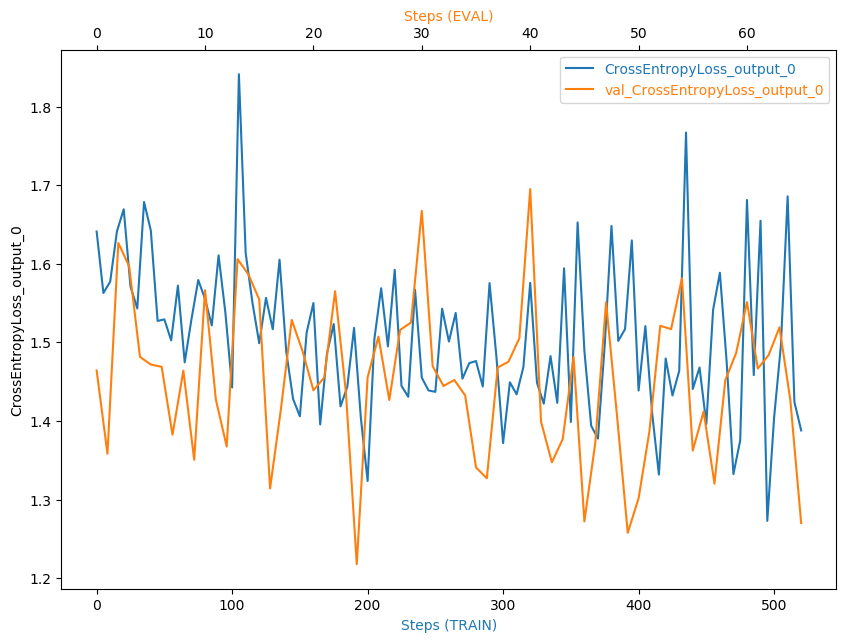

In [61]:
# TODO: Plot a debugging output.
tensor_name = "CrossEntropyLoss_output_0"
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    fig.savefig('loss.jpg')
    plt.show()

plot_tensor(trial, tensor_name)

In [ ]:
# Display the profiler output
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [84]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
- There is anomalous behaviour as the line should be more smooth line and decrease by increasing steps in the debugger report.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [16]:
model_location= "s3://sagemaker-us-east-1-365169303064/Amazon-Inventory-Reconciliation-2023-02-19-17-28-21-652/output/model.tar.gz"

In [17]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [18]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [24]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [27]:
# TODO: Deploy your model to an endpoint
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


------!

In [22]:
# TODO: Run an prediction on the endpoint
import requests
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/523.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

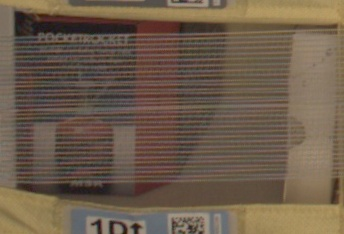

In [117]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [28]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [29]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [30]:
type(response2[0][0])

float

In [31]:
response2[0]

[-0.820949375629425,
 0.30063921213150024,
 0.3247339427471161,
 0.20037591457366943,
 0.004278808832168579]

In [34]:
import numpy as np
np.argmax(response2, 1)

array([2])

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [12]:
# TODO: Train your model on Multiple Instances
estimator = PyTorch(
    entry_point='train.py',
    base_job_name='Amazon-Inventory-Reconciliation',
    role=role,
    instance_count=2,
    instance_type='ml.m5.xlarge',
    framework_version='1.8.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [13]:
estimator.fit({"training": "s3://sagemaker-us-east-1-365169303064/"}, wait=True)

2023-02-20 18:04:28 Starting - Starting the training job...
2023-02-20 18:04:53 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-02-20 18:05:53 Downloading - Downloading input data.........
2023-02-20 18:07:21 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-20 18:07:20,557 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-20 18:07:20,559 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-20 18:07:20,569 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-20 18:07:20,571 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-20 18:07:20,739 sa